<div class='alert-block alert-info'>
    <br>
    <h1 align="center"><b>  Lab session 3 :</b> Local search </h1>
    <h3 align="center">Artificial Intelligence Algorithms </h3>
    <h5 align="center">MESIIN476023</a></h5>
    <br>
</div>

#### CONTENTS

<font color='black'></front>    
* **Part I: Traveling Salesman Problem**
    * Problem definition
    * TSP class 
    * How hard is the problem

* **Part II: Greedy search**

<font color='black'></front>
* **Part III: Local search algorithms**

    1. <font color='black'>Hill climbing</front>
         -  <font color='darkred'> Exercice 1</front>

    2. <font color='black'>Simulated annealing</front>

         -  <font color='darkred'> Exercice 2</front>
  
    3. <font color='black'>Genetic algorithm</front>

         -  <font color='darkred'> Exercice 3</front>
    4.  <font color='darkred'> Exercice 4</front>
    </br>

<font color='black'></front>
#### Overview
In this lab session, you will check your understanding by implementing local search algorithms as covered in Lecture 5. We'll explore the Traveling Salesman Problem (TSP) using Romanian capital cities as an example.  The TSP is an optimization challenge aiming to find the shortest route that visits each city only once, and in our scenario, it starts and ends in the same city, forming a closed loop.

To ensure a thorough understanding of the concepts, take time to immerse yourself in the in-depth descriptions provided within the notebook. Demonstrate your comprehension by answering the questions and completing the requested implementations.


#### <font color='darkblue'>**Submission**</front>

- Complete exercises 1 to 5 in the notebook for this practical session.
- Submit your completed notebook to the designated area: section Lab sessions –> Lab3 –> Deposit DIA *) on De Vinci Learning.

- You may collaborate with one other classmate on this assignment. Please include both names at the top of the notebook or in the file name for clarity.

- The deadline is before the next lab session.







<h1 align="left"> <font color='darkblue'> Part I: Problem definition - Traveling Salesman Problem </font></a></h1>  



The Traveling Salesman Problem (TSP) is given by the following question: “Given is a list of cities and distances between each pair of cities - what is the shortest route that visits each city and returns to the original city?”
The TSP is an NP-Hard-Problem which does not mean an instance of the problem will be hard to solve. It means, there does not exist an algorithm that produces the best solution in polynomial time. We can not make predictions about how long it might take to find the best solution. But, we can find a good solution which might not be the best solution. 

We propose in this lab session to consider the map of Romania to address the traveling salesman problem.




### I.a. Representation of the Problem

To approach the TSP problem, we need to construct a representation of the problem domain. The choice of representation can significantly influence the performance of search optimization techniques. Here, we propose to represent the map as an undirected weighted graph. In this graph, each node represents a city and its coordinates, while the edges represent the links between the cities and their corresponding distances. The path is defined as the sequence generated by traveling from one city in the list to the next in order.

For the distances between every pair of cities on the Romania map, we propose using the Manhattan Distance. The Manhattan distance between two points $(x_1,y_1)$ and $(x_2,y_2)$ is given by $|x_1-x_2| + |y_1-y_2|$.

In [1]:
# ===================================================================
# Import necessary modules

from search import *
from Complementary_notebook import psource, heatmap, gaussian_kernel, show_map2, show_map3, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines
from collections import defaultdict, deque, Counter

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

Let's describe the Romania_map, which is an undirected graph consisting of a dictionary with nodes as keys and neighbors as values.

In [3]:
romania_map = UndirectedGraph()

locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))



for city1 in locations:
    for city2 in locations:
        if city1 != city2:
            distance = manhattan_distance(locations[city1], locations[city2])
            romania_map.connect(city1, city2, distance)




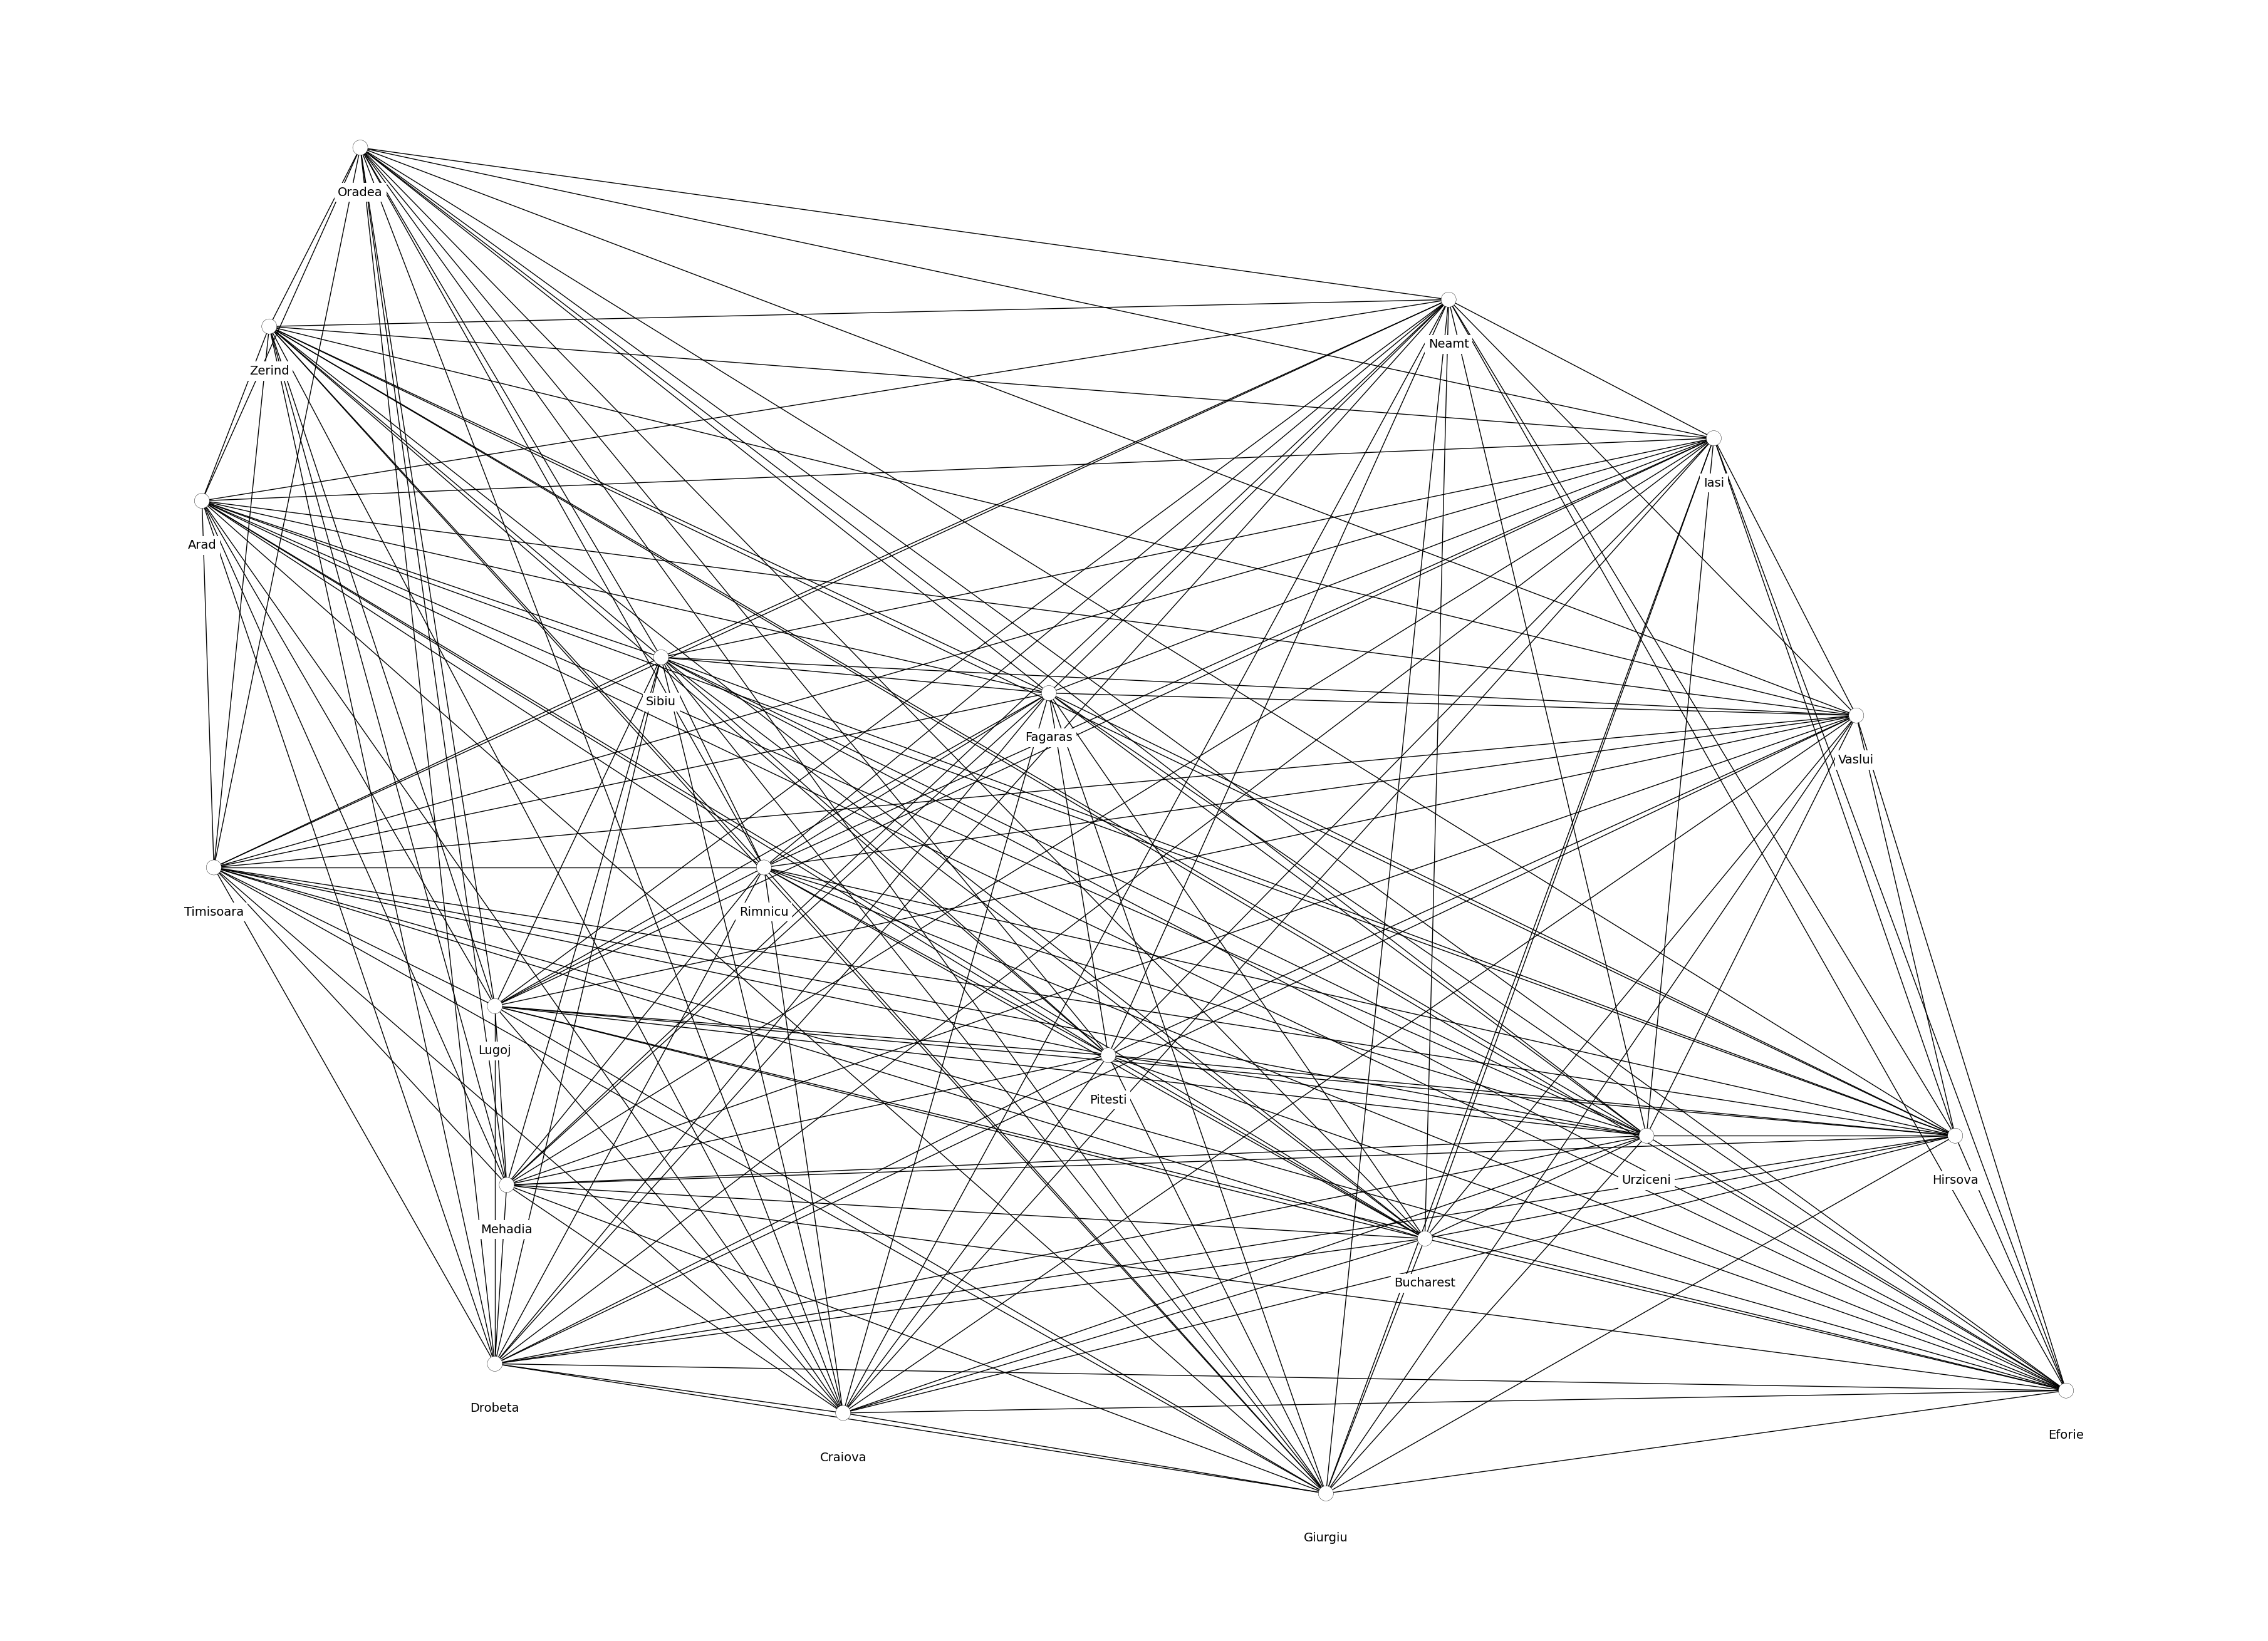

In [4]:
romania_locations =locations
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in locations.keys()}
node_positions = locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                      'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }
show_map2(romania_graph_data) # We do not display the edge weights to avoid cluttering the visualization of the graph.

A list of all cities and a dictionary storing distances between them will be populated.


In [5]:
import numpy as np

distances = {}
all_cities = []

for city in locations.keys():
    distances[city] = {}
    all_cities.append(city)

all_cities.sort()



# List of cities
cities = list(locations.keys())
num_cities = len(cities)

# distances for connected cities
for city1 in all_cities:

    for city2 in all_cities:
        if city2 in romania_map.graph_dict.get(city1, {}):
            distances[city1][city2] = romania_map.graph_dict[city1][city2]


### I.b. Define the TSP problem

We need to define a class for this problem. "Problem" class implemented in search.py module will be used as a base class.

In [6]:
# ===================================================================
# defining the TSP problem

class TSP_problem(Problem):

    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem
        This function generates a neighbour state by reversing part of the path
        (e.g., reverse the BCD sequence in [ABCDE] to get [ADCBE] as the successor). We will see this function later in the lab session.
        """

        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state
    
    def swap(self, state):
        """ Neighbour generating function for Traveling Salesman Problem"""
        neighbour_state = state[:]
        swap_element = random.randint(0, len(neighbour_state) - 1)
        swap_order = random.randint(0,1)
        if swap_order == 0:
            if swap_element == 0:
                neighbour_state[swap_element], neighbour_state[-1] = neighbour_state[-1], neighbour_state[swap_element]
            else:
                neighbour_state[swap_element], neighbour_state[swap_element-1] = neighbour_state[swap_element-1], neighbour_state[swap_element]
        else:
            if swap_element == len(neighbour_state) - 1:
                neighbour_state[swap_element], neighbour_state[0] = neighbour_state[0], neighbour_state[swap_element]
            else:
                neighbour_state[swap_element], neighbour_state[swap_element+1] = neighbour_state[swap_element+1], neighbour_state[swap_element]
        return neighbour_state
    
    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]


        cost += distances[state2[0]][state2[-1]]

        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return -self.path_cost(None, None, None, state) #-1 * self.path_cost(None, None, None, state)

1. **two_opt(state):** The two-opt method is a simple local search method used to improve an existing tour in the TSP. It works by taking any two non-adjacent links in the tour and reversing them to see if that yields an improvement in the tour's total distance. The function generates a neighboring state of the given state by reversing a sub-segment of the route. We will describe this function in more detail later in the lab exercise.

2. **actions(state):** Returns the possible actions that can be executed in a given state.

3. **result(state, action):** Returns the state that results from executing the given action on the provided state.


4. **path_cost(c, state1, action, state2):** Calculates and returns the total distance of the tour represented by state2. It sums up the distances between consecutive cities in the tour and adds the distance from the last city back to the first city to complete the loop.


5. **value(state):** Returns the negative of the path cost for the given state. The reason for returning a negative value is because in optimization problems like the TSP, we often want to minimize the cost. But if the search algorithm is built to maximize the value, by representing the cost as a negative value, the algorithm can continue to work in a maximization mode.


**Remark:** Search algorithms, including hill-climbing and simulated annealing, are designed to maximize a given function. To bridge this gap and use these algorithms directly, the function being maximized (in this case, the value function) returns the negative of the path cost. By doing this, minimizing the path cost translates to maximizing the negative of the path cost.

**Instantiate the TSP problem**

An instance of the TSP_problem class will be created.

In [7]:
# construct an instance of the TSP
tsp = TSP_problem(all_cities)

### How hard is the problem?

How hard is this problem? It turns out that TSP is as hard as they come. We call this NP hard. It is very hard because there are so many possibilities, and each new city multiplies those possibilities. And, the problem can't be divided into subproblems.

For an 𝑛 city problem, there are factorial(𝑛−1) possible routes. To determine if we have found the shortest path, we might need to check all of the possible routes. However, that can be an overwhelming number. This kind of problem has a complexity of $O(n!)$ (where $n!$ stands for factorial of $n$), making it often called as intractable.
Considering the case of a Romanian map with 20 cities, the number of possible routes would be:

In [8]:
def factorial(n):
    retval = 1
    for i in range(1, n + 1):
        retval = retval * i
    return retval

factorial(20-1)

121645100408832000

<h1 align="left"> <font color='darkblue'> Part II: Greedy search  </font></a></h1>  

How can we solve this problem of searching for the optimal/best path? 

As an example, suppose that you could just pick the closest city to visit at each city. This is called a "greedy" method, because it greedily picks the locally closest.

How good is it?

In [9]:
def greedy_tsp(problem, start=None):
    """Greedy algorithm to solve the TSP."""
    current_city = start or random.choice(problem.initial)
    path = [current_city]
    unvisited_cities = set(problem.initial) - {current_city}

    while unvisited_cities:
        next_city = min(unvisited_cities, key=lambda city: problem.path_cost(None, current_city, None, [current_city, city]))
        path.append(next_city)
        unvisited_cities.remove(next_city)
        current_city = next_city


    cost = problem.path_cost(None, None, None, path)
    return path, cost

# Running the greedy algorithm for the TSP
greedy_route, greedy_cost = greedy_tsp(tsp)
print("Best Route:", greedy_route)
print("Best Cost:", greedy_cost)


Best Route: ['Timisoara', 'Arad', 'Zerind', 'Oradea', 'Sibiu', 'Rimnicu', 'Lugoj', 'Mehadia', 'Drobeta', 'Craiova', 'Giurgiu', 'Bucharest', 'Urziceni', 'Hirsova', 'Eforie', 'Vaslui', 'Iasi', 'Neamt', 'Fagaras', 'Pitesti']
Best Cost: 2168


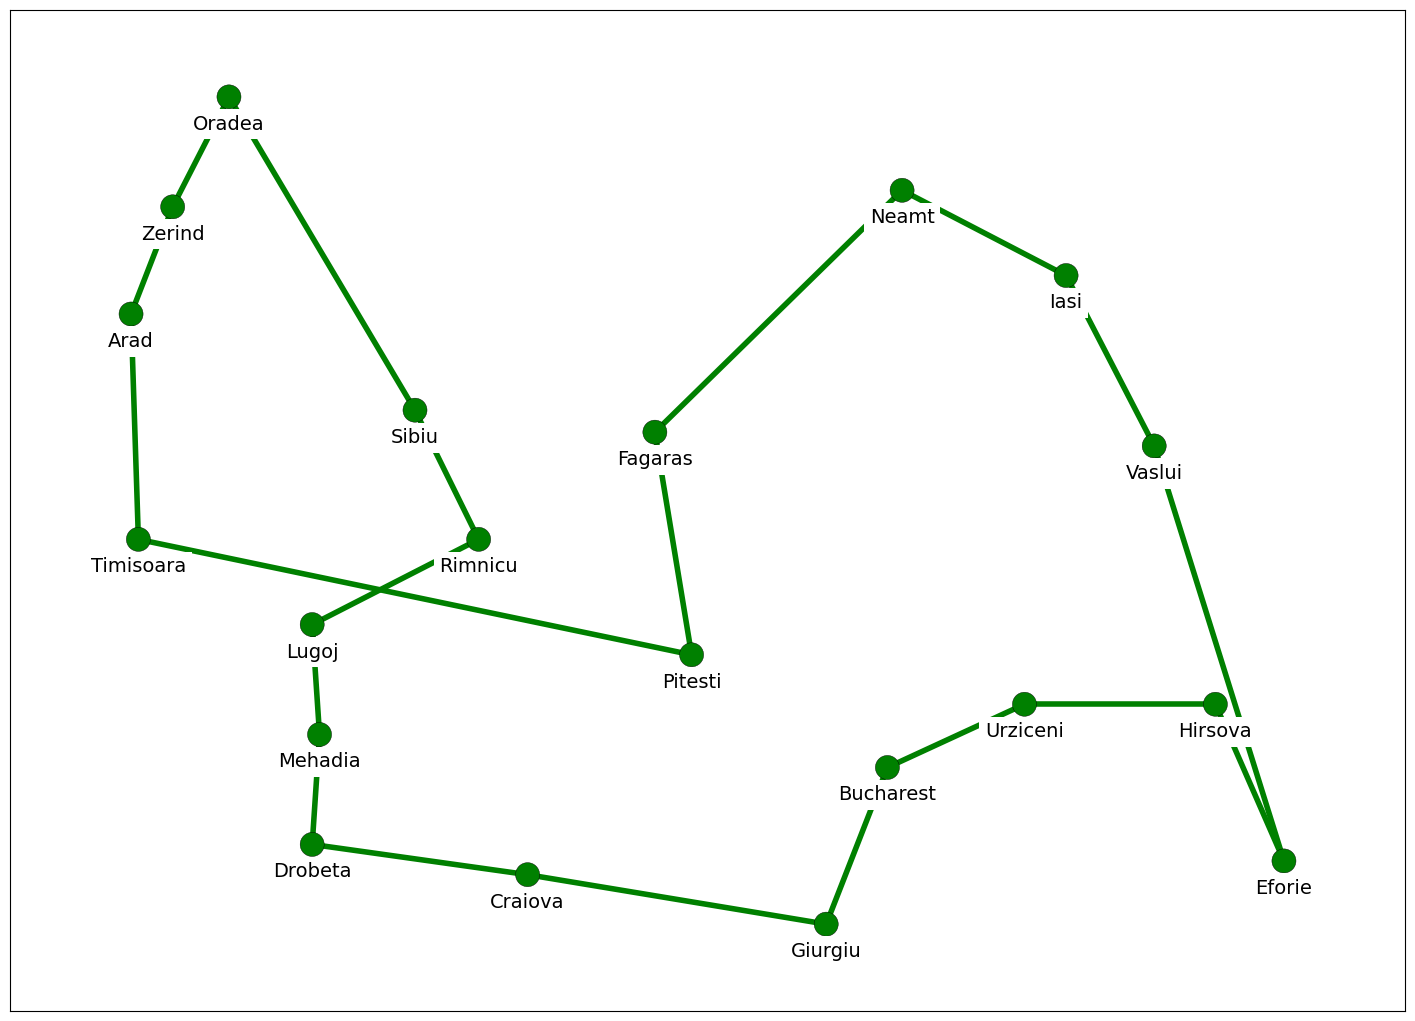

In [10]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in greedy_route }

show_map3(romania_graph_data,node_colors,greedy_route)

Not very good. Ok, let's try some other algorithms

<h1 align="left"> <font color='darkblue'> Part III: Local search algorithms </font></a></h1>  


In this part, we will delve into the three local search algorithms that were covered in our lectures, ie., the Hill Climbing algorithm, Simulated Annealing, and the Genetic Algorithm.

<h2 align="left"> II.1.Hill Climbing </h2>

* **Idea:**
    - use only your local solution and evaluate your neighbors to find a better one
    - repeat this step until no better neighbor exists
* **Pros:**
    - requires few resources (current state and neighbors)
    - finds local optimum (global is possible)
    - useful if the search space is huge (even unlimited)
* **Cons:**
    - is prone to get stuck at the top of local maximum and on plateaus
    - strongly depends on “good” initialization

The algorithm works as follows:
 * Evaluate the initial state.
 * If it is equal to the goal state, return.
 * Find a neighboring state (one which is heuristically similar to the current state)
 * Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps.

In [11]:
def hill_climbing(problem):
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. Returns the final state."""

    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem) 
        if not neighbors:
            break
        neighbor = max(neighbors, key=lambda node: problem.value(node.state)) # select the one with best fitness value

        if problem.value(neighbor.state) > problem.value(current.state):
            break
        current = neighbor
    return current.state, -problem.value(current.state)

In [12]:
# Using the hill_climbing search on the TSP_problem:
solution, value = hill_climbing(tsp)
print("Hill Climbing solution:", solution)
print("Total distance:", value)

Hill Climbing solution: ['Arad', 'Vaslui', 'Urziceni', 'Zerind', 'Bucharest', 'Rimnicu', 'Pitesti', 'Oradea', 'Neamt', 'Mehadia', 'Lugoj', 'Iasi', 'Hirsova', 'Giurgiu', 'Fagaras', 'Eforie', 'Drobeta', 'Craiova', 'Sibiu', 'Timisoara']
Total distance: 5712


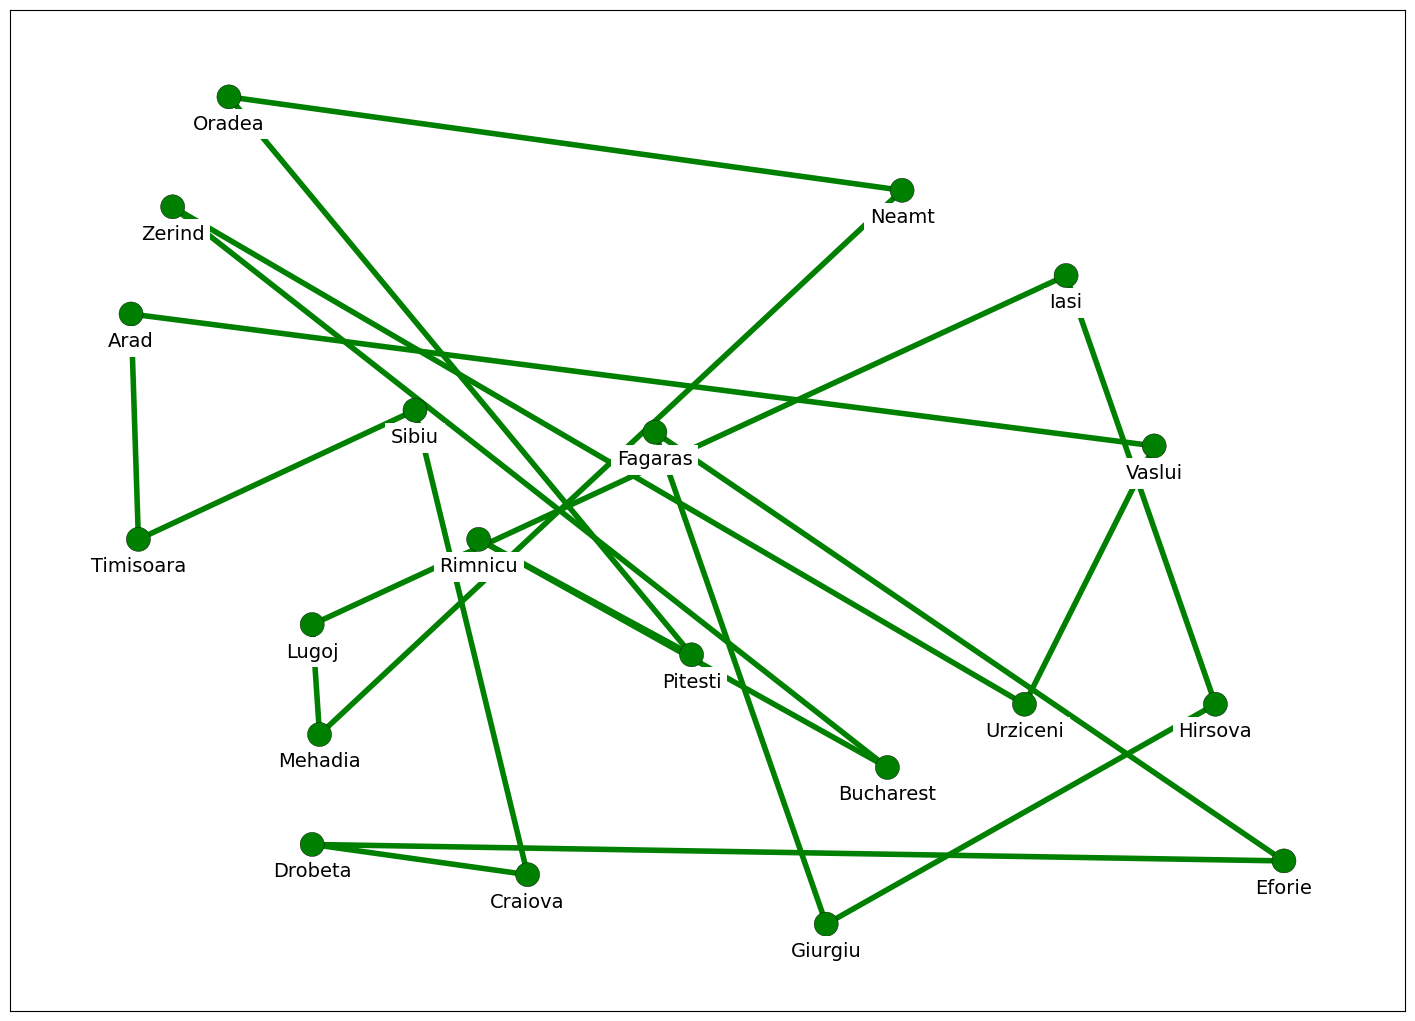

In [13]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in solution }

show_map3(romania_graph_data,node_colors,solution)

**Succesors generation**

There are several ways to generate successors for Hill Climbing.
1. By swapping any pair of cities in the path, 
2. Through insertion, ie., removing a city from one position in the route and inserting it in another position. For example, moving C between D and E in the route [A, B, C, D, E] would give [A, B, D, C, E].
3. By reversing part of the path (e.g., reverse the BCD sequence in [ABCDE] to get [ADCBE] as the successor).

The `expand` method in the previous code likely generates neighbors using one or a combination of the methods mentioned above. 
However, this approach to choosing neighbors might not be the most suited for the Traveling Salesperson Problem.  We suggest testing the 3rd strategy and observe its impact on Hill Climbing's performance. Note that the function two_opt defined in the TSP_problem class implements the 3rd strategy.


In [14]:
def hill_climbing_two_opt(problem):

    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. Returns the final state. """

    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """

        neighbors = []

        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state

        return neighbors

    iterations = 10000
    fit_list = []
    states = []
    current = Node(problem.initial)
    fit_list=[-problem.value(current.state) ]

    while iterations:
        neighbors = find_neighbors(current.state)
        #print(neighbors)
        if not neighbors:
            break
        #neighbor = argmax_random_tie(neighbors,key=lambda node: problem.value(node.state))
        neighbor = max(neighbors, key=lambda node: problem.value(node.state))

        if problem.value(neighbor.state) > problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        states.append(current.state)
        fit_list.append(-problem.value(current.state))


    return current.state, -problem.value(current.state),states,fit_list

We can now generate an approximate solution to the problem by calling hill_climbing. The results will vary a bit each time you run it.

In [15]:
# Using the hill_climbing search on the TSP_problem:
solution, value,states,fit_list= hill_climbing_two_opt(tsp)
print("Hill Climbing solution:", solution)
print("Total distance:", value)

Hill Climbing solution: ['Mehadia', 'Lugoj', 'Timisoara', 'Arad', 'Zerind', 'Oradea', 'Neamt', 'Iasi', 'Vaslui', 'Hirsova', 'Eforie', 'Urziceni', 'Bucharest', 'Giurgiu', 'Pitesti', 'Fagaras', 'Sibiu', 'Rimnicu', 'Craiova', 'Drobeta']
Total distance: 2094


The solution looks like this.

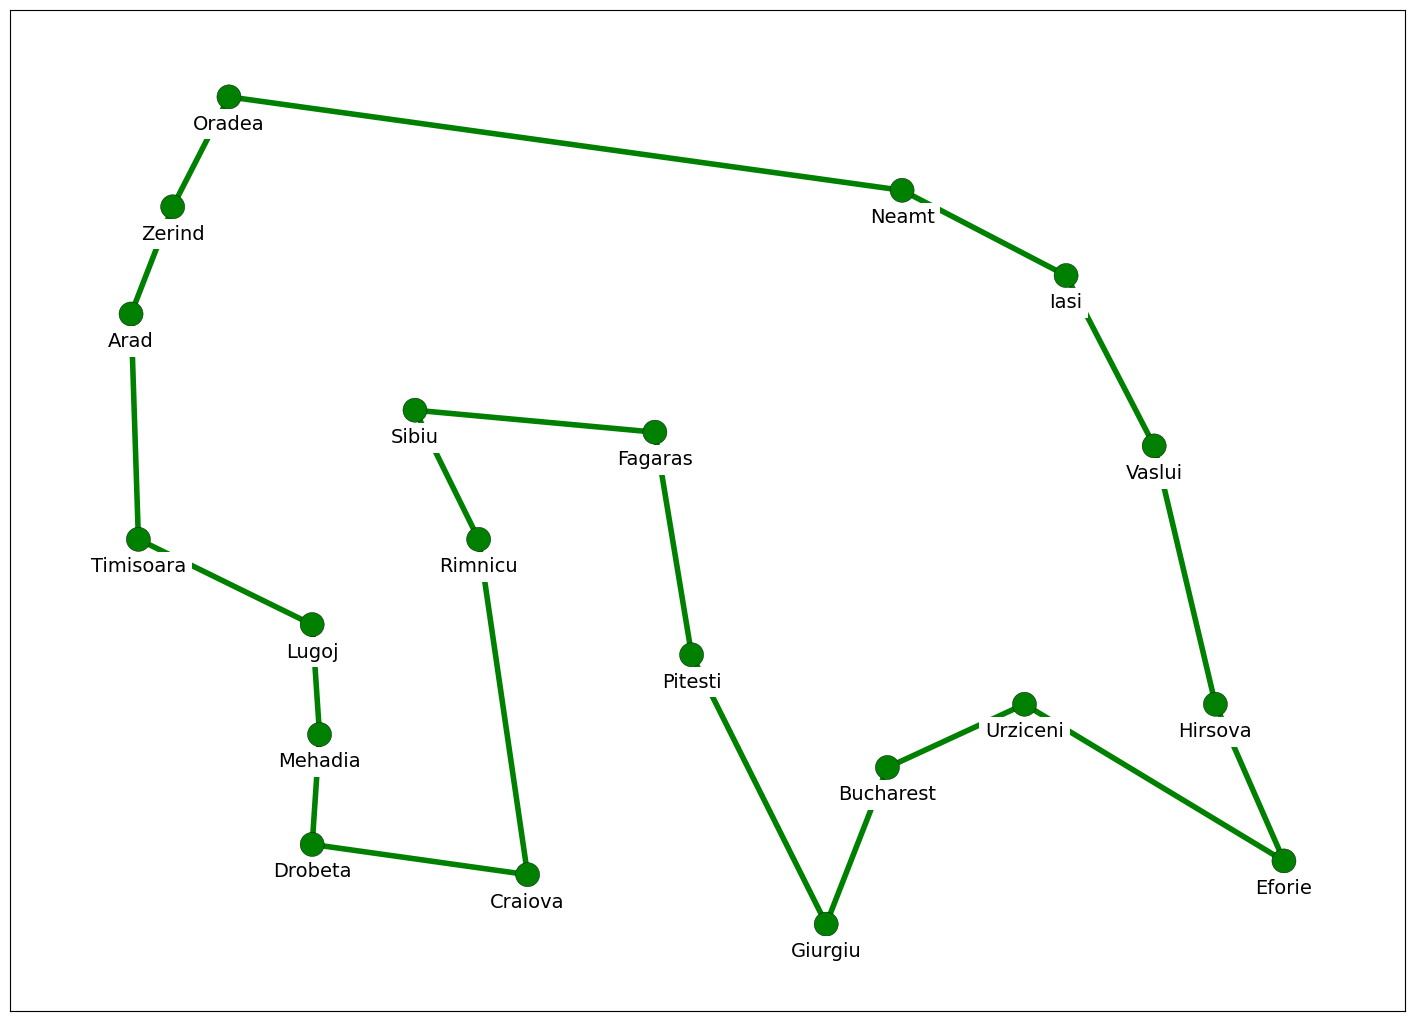

In [16]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in solution }

show_map3(romania_graph_data,node_colors,solution)

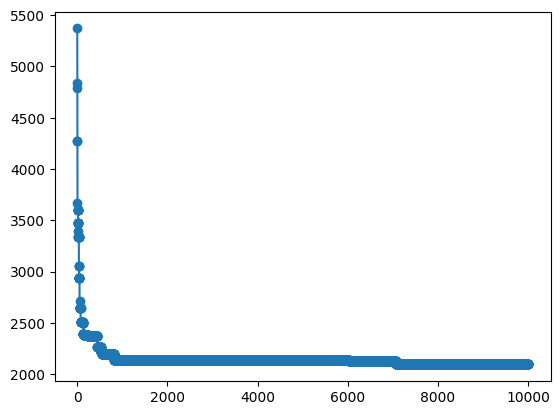

In [17]:
plt.plot(fit_list,marker="o")

In [18]:
sim=[]
for i in range(10):
    state, value, states,fit_list = hill_climbing_two_opt(tsp)
    sim.append(value)
print(sim)
print('shortest tour through HC: ', min(sim))

[2148, 2160, 2032, 2078, 2032, 2032, 2136, 2136, 2032, 2136]
shortest tour through HC:  2032



It is not difficult to see why this might be a good solution.

**Remark:** Remember, hill climbing might get stuck in local optima, so it might not always find the best possible solution. Depending on your problem instance and the landscape of your solution space, you might want to run hill climbing multiple times from different starting positions or use other algorithms like simulated annealing which has a mechanism to escape local optima.

#### <font color='darkred'>**Exercice 1**</front>
<font color='darkred'>Attempt to implement one of the two outlined strategies for generating neighbors: 1. By swapping any pair of cities in the path, or 2. Through insertion. What impact does this change have on HC performances?</front>

ADDED SWAP METHOD TO TSP CLASS :
def swap(self, state):
        """ Neighbour generating function for Traveling Salesman Problem"""
        neighbour_state = state[:]
        swap_element = random.randint(0, len(neighbour_state) - 1)
        swap_order = random.randint(0,1)
        if swap_order == 0:
            if swap_element == 0:
                neighbour_state[swap_element], neighbour_state[-1] = neighbour_state[-1], neighbour_state[swap_element]
            else:
                neighbour_state[swap_element], neighbour_state[swap_element-1] = neighbour_state[swap_element-1], neighbour_state[swap_element]
        else:
            if swap_element == len(neighbour_state) - 1:
                neighbour_state[swap_element], neighbour_state[0] = neighbour_state[0], neighbour_state[swap_element]
            else:
                neighbour_state[swap_element], neighbour_state[swap_element+1] = neighbour_state[swap_element+1], neighbour_state[swap_element]
        return neighbour_state

In [19]:
def hill_climbing_swap(problem):

    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. Returns the final state. """

    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """

        neighbors = []

        for i in range(number_of_neighbors):
            new_state = problem.swap(state)
            neighbors.append(Node(new_state))
            state = new_state

        return neighbors

    iterations = 10000
    fit_list = []
    states = []
    current = Node(problem.initial)
    fit_list=[-problem.value(current.state) ]

    while iterations:
        neighbors = find_neighbors(current.state)
        #print(neighbors)
        if not neighbors:
            break
        #neighbor = argmax_random_tie(neighbors,key=lambda node: problem.value(node.state))
        neighbor = max(neighbors, key=lambda node: problem.value(node.state))

        if problem.value(neighbor.state) > problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        states.append(current.state)
        fit_list.append(-problem.value(current.state))


    return current.state, -problem.value(current.state),states,fit_list

In [20]:
# Using the hill_climbing search on the TSP_problem:
solution, value,states,fit_list= hill_climbing_swap(tsp)
print("Hill Climbing solution:", solution)
print("Total distance:", value)

Hill Climbing solution: ['Vaslui', 'Arad', 'Lugoj', 'Mehadia', 'Drobeta', 'Craiova', 'Giurgiu', 'Bucharest', 'Urziceni', 'Iasi', 'Neamt', 'Fagaras', 'Sibiu', 'Oradea', 'Zerind', 'Timisoara', 'Rimnicu', 'Pitesti', 'Hirsova', 'Eforie']
Total distance: 2882


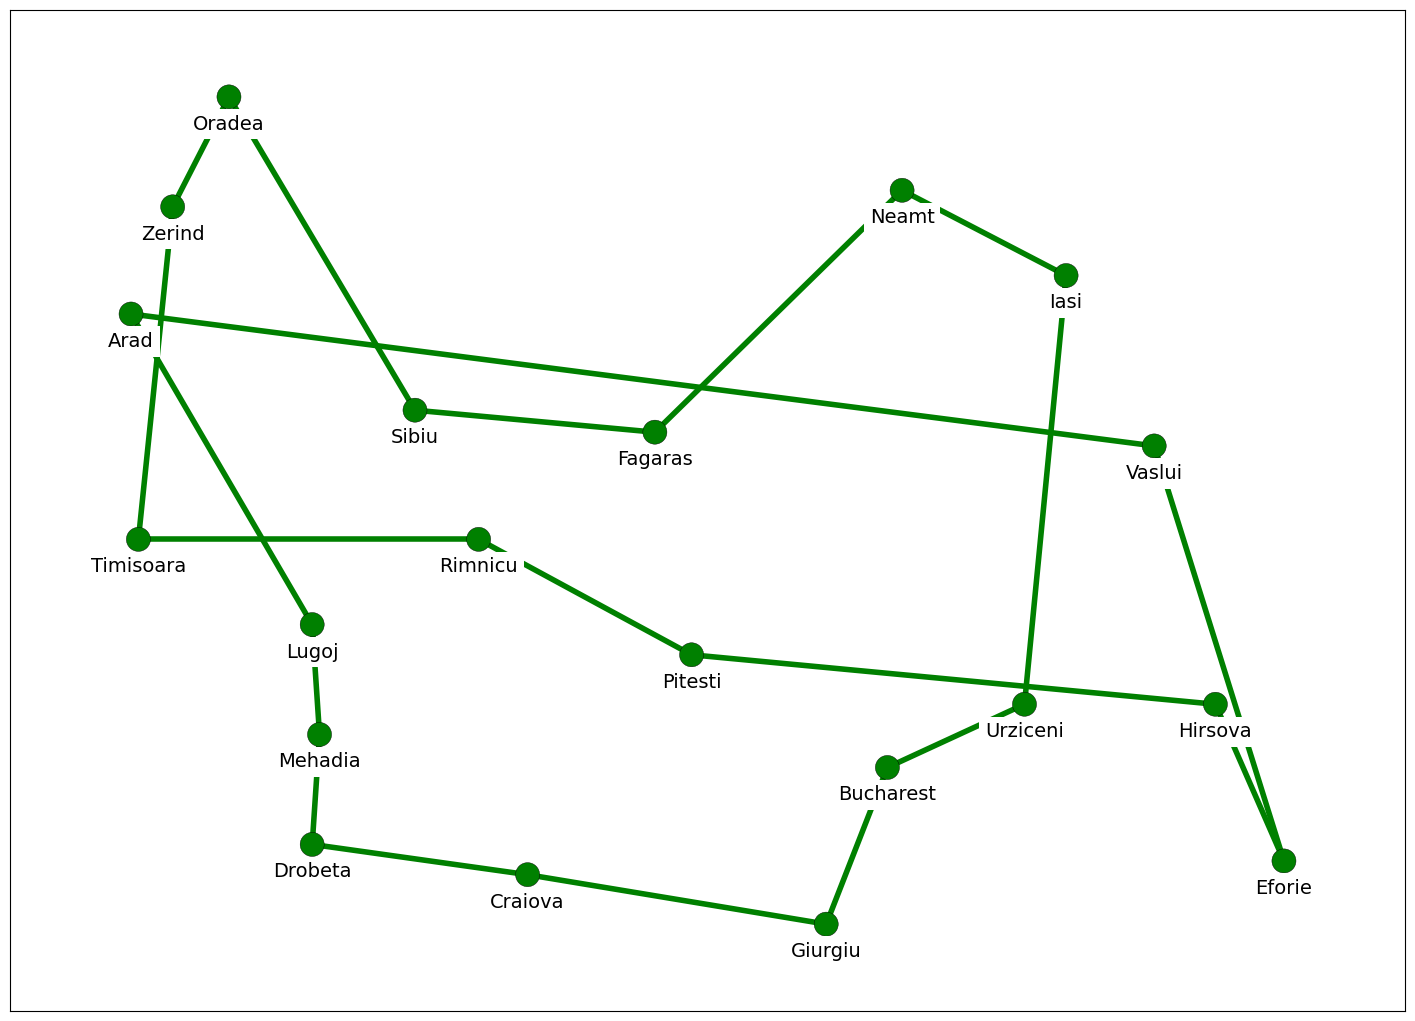

In [21]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in solution }

show_map3(romania_graph_data,node_colors,solution)

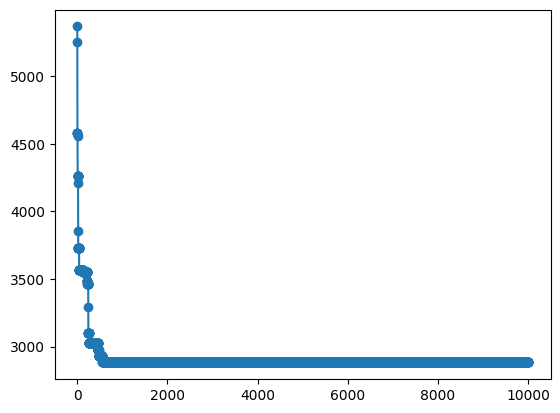

In [22]:
plt.plot(fit_list,marker="o")

In [23]:
sim=[]
for i in range(10):
    state, value, states,fit_list = hill_climbing_swap(tsp)
    sim.append(value)
print(sim)
print('shortest tour through HC: ', min(sim))

[2848, 2798, 3180, 2932, 2818, 2680, 3454, 2958, 2690, 2792]
shortest tour through HC:  2680


The performance is a lot worse than the two_opt method.
We see that in the romanian map and the shortest tour, which is 2032 for the two_opt method and 2680 for the swap method, proving that the two_opt method is better.

<h2 align="left"> II.2. Simulated Anealling </h2>

**Applying simulated annealing in traveling salesman problem to find the shortest tour to travel all cities in Romania.**

***Note:** The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. There is a fundamental problem in the implementation of the algorithm however. To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. The algorithm will always converge to the local optimum. Hill Climbing is also bad at dealing with functions that flatline in certain regions. If all neighboring states have the same value, we cannot find the global optimum using this algorithm.*

*Let's now look at an algorithm that can deal with these situations.
Simulated Annealing is quite similar to Hill Climbing, but instead of picking the best move every iteration, it picks a random move. If this random move brings us closer to the global optimum, it will be accepted, but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the temperature. When the temperature is high, the algorithm is more likely to accept a random move even if it is bad. At low `temperature`, only good moves are accepted, with the occasional exception. This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.*

The temperature is gradually decreased over the course of the iteration. This is done by a scheduling routine. The current implementation uses exponential decay of temperature, but we can use a different scheduling routine instead.

In [24]:
def exponential_schedule(temperature=1e4, alpha=0.95, limit=1000):
    """One possible schedule function for simulated annealing, decreasing the temperature exponentially."""
    return lambda t: (temperature * np.exp(-alpha * t) if t < limit else 0)

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  

In [25]:
def simulated_annealing(problem, schedule=exponential_schedule()):
    """Performs simulated annealing search.

    Parameters:
    - problem: the problem for which the solution is to be found.
    - schedule: a function that takes an iteration count and returns a temperature.

    Returns:
    - state: the best solution state found.
    - value: the value of the best solution found.
    - states: a list of states representing the process.


    for t = 1 to ∞ do
       T ← schedule(t)
       if T = 0 then return current
       next ← a randomly selected successor of current
       ΔE ← next.VALUE - current.VALUE
       if ΔE > 0 then current ← next
       else current ← next only with probability eΔE/T
    """

    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """

        neighbors = []

        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state

        return neighbors


    current = Node(problem.initial)
    states = [current.state]
    fit_list=[-problem.value(current.state)]

    for t in range(sys.maxsize): # for simplicity, we can run until 10,000 iterations; you can adjust this as desired
        T = schedule(t)
        if T == 0:
            return current.state, -problem.value(current.state),states,fit_list
        neighbors = current.expand(problem)

        if not neighbors:
            return current.state, -problem.value(current.state),states,fit_list
        next_choice = random.choice(neighbors)
        delta_e = problem.value(next_choice.state) - problem.value(current.state)

        if delta_e > 0 or random.uniform(0, 1) < np.exp(delta_e / T):
            current = next_choice
            states.append(current.state)
            fit_list.append(-problem.value(current.state))


In [26]:
state, value, states,fit_list = simulated_annealing(tsp)
#print("Simulated annealing solution:", state)
print("SA Total distance:", value)

SA Total distance: 2032


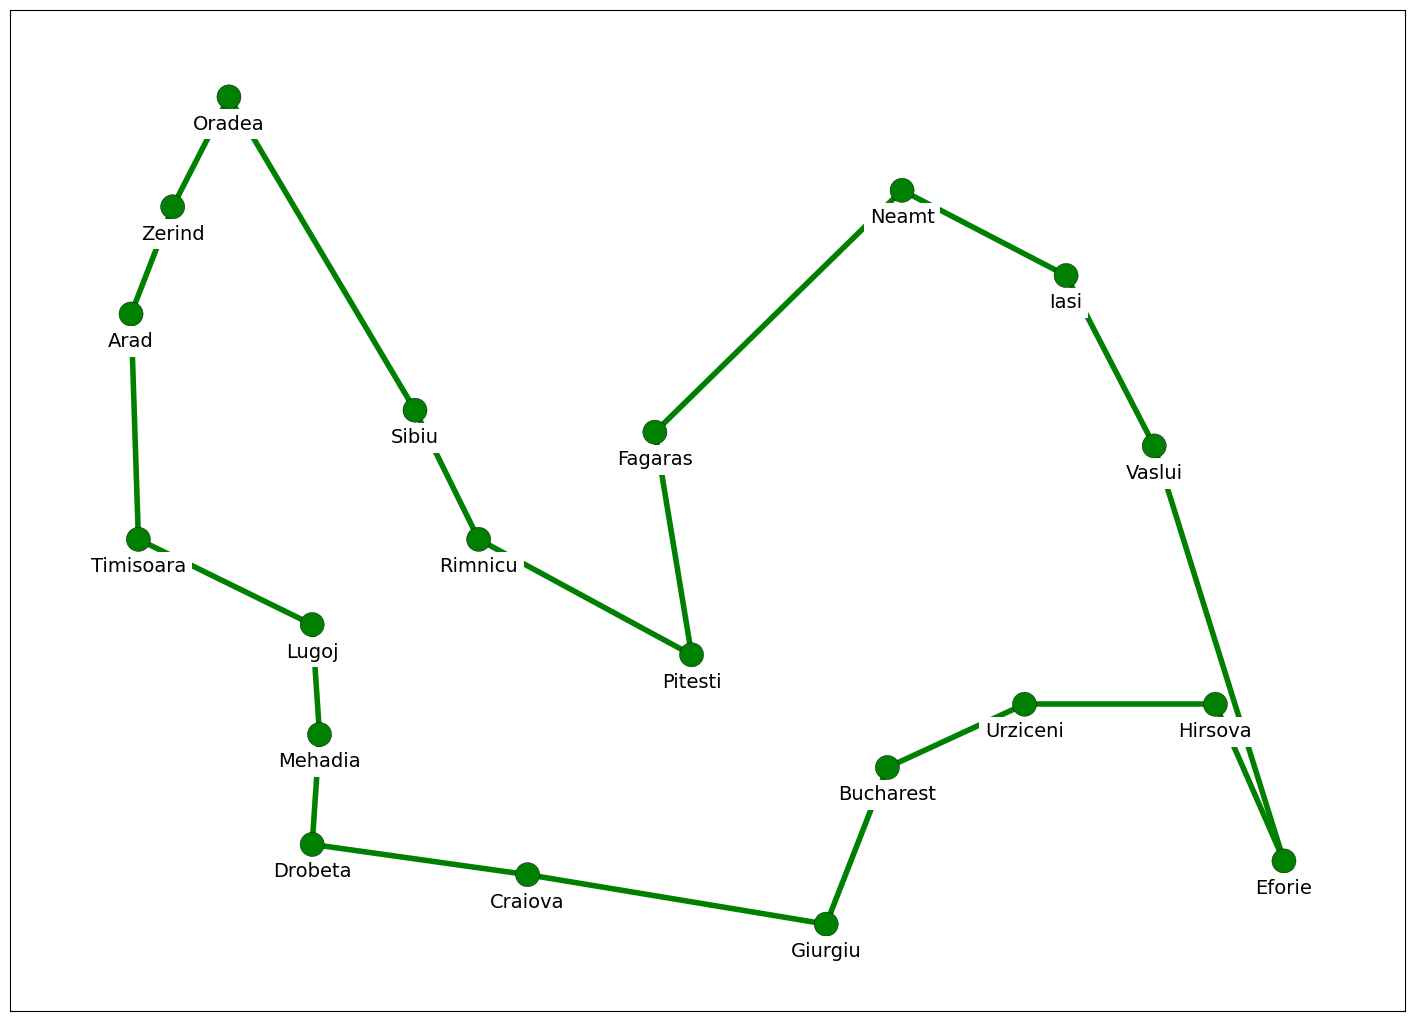

In [27]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in state }

show_map3(romania_graph_data,node_colors,state)

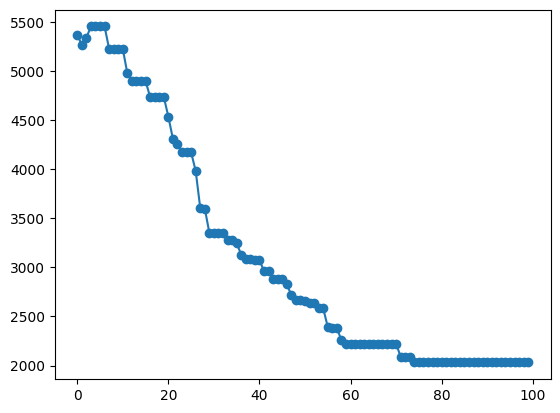

In [28]:
plt.plot(fit_list,marker="o")

In [29]:
sim=[]
for i in range(20):
    state, value, states,fit_list = simulated_annealing(tsp)
    sim.append(value)
print(sim)
print('shortest tour through SA: ', min(sim))


[2032, 2186, 2314, 2106, 2146, 2260, 2142, 2218, 2094, 2160, 2176, 2142, 2162, 2276, 2260, 2186, 2032, 2138, 2152, 2124]
shortest tour through SA:  2032


### <font color='darkred'>**Exercice 2**</front>
<font color='darkred'>1. Modify the `alpha` and `temperature` parameters. How do they affect the results?
</front>

    The temperature parameter defines the beginning temeperature, allowing for more exploration at the beginning of the algorithm. The alpha parameter defines the rate of decay of the temperature, allowing for a slower or faster decay, thus influencing how low the temperature will get.
    
<font color='darkred'>2. Test SA with other schedule functions, such as linear, Logarithmic, quadratic, etc (try only one of them). Reflect on how modifying the temperature schedule impacts the behavior and results of the simulated annealing algorithm. Does the algorithm maintain its efficacy?
   </front>

<h2 align="left"> II.3.  Genetic Algorithm </h2>

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.
Given a problem, algorithms in the domain make use of a population of solutions (also called states), where each solution/state represents a feasible solution. At each iteration (often called generation), the population gets updated using methods inspired by biology and evolution, like crossover, mutation and natural selection.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations was reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Implementation

1. Initialization: Start with a population of randomly generated routes.
2. Define the fitness function
3. Selection: Select the best routes based on their fitness (shortest distances).
4. Crossover (Recombination): Create new routes by combining pairs of the best routes.
5. Mutation: Introduce random changes into the new routes.
6. Replacement: Replace the old population with the new population of routes.
7. Termination: Stop if a maximum number of iterations is reached or if the best route hasn't improved for a certain number of iterations.


Here's the implementation:

#### 1. Initialization


In the initialization step of a Genetic Algorithm (GA), a population of potential solutions (often termed "individuals" or "chromosomes") is generated randomly, providing a diverse starting point for the search process.

In [30]:
def init_population(problem,population_size):
    """Initialize a population of routes (lists of cities)."""
    return [random.sample(problem.initial, len(problem.initial)) for _ in range(population_size)]

#### 2. Fitness function

The fitness function evaluates and assigns a score to an individual in a population based on its suitability to solve the given problem. At each GA iteration, the fittest individuals are picked to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual.

In [31]:
def fitness(problem,route):
    return problem.path_cost(None, None, None, state) #problem.value(route)

#### 2. Selection



The selection phase in a Genetic Algorithm (GA) chooses individuals from the current population to serve as parents for the next generation, based on their fitness. This process mimics natural selection, favoring higher fitness individuals while maintaining some genetic diversity to prevent premature convergence.


The selection procedure can be summarized as:

1) Individuals are scored by the fitness function.

2) Individuals are picked based on some selection strategies (greedy, roulette wheel, rank, or Elitism  selections)



Hereafter, we propose to implement a combined approach of Elitism and Roulette Wheel Selection:

- **Elitism:** Directly selects the best routes or individuals (elites) based on their fitness. This ensures that the best solutions from the current generation are preserved in the next generation.

- **Roulette Wheel Selection** (or Fitness Proportionate Selection): The rest of the population is selected based on a probability proportional to their fitness. In other words, individuals with higher fitness values have a higher chance of being selected, but even those with lower fitness values still have some chance. Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

In [32]:
def select_elitismRoulette(problem, population,n_population,elite_size):
    # Select best routes (elites) directly
    n_elites = int(elite_size * n_population)
    elites = sorted(population, key=lambda route: fitness(problem, route), reverse=True)[:n_elites]
    # Randomly select the rest based on a probability proportional to their fitness
    weights = [fitness(problem,route) for route in population]
    selected = random.choices(population, weights, k=n_population - n_elites)
    return elites + selected

##### <font color='darkred'>**Exercice 3.1**</front>
 - <font color='darkred'>Implement a selection strategy that combines elitism and rank selections. **Rank selection** in GA  chooses individuals based on their relative performance rather than their actual fitness scores.</front>
##### <font color='darkred'>**Exercice 3.2**</front>
- <font color='darkred'>Implement the tournament selection method. **In tournament selection**, a set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.</front>

#### 3. Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* **Point Crossover:** The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](images/point_crossover.png)


* **Uniform Crossover:** This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](images/uniform_crossover 2.png)

Here is an implementation for one point crossover.

In [33]:
def one_point_crossover(parent1, parent2):

    # Choose one crossover point
    crossover_point = random.randint(0, len(parent1)-1)

    # Start by copying genes from parent1 up to the crossover point
    child = parent1[:crossover_point]

    # Then fill the rest of the child with genes from parent2 that aren't already in the child
    for city in parent2:
        if city not in child:
            child.append(city)

    return child

##### <font color='darkred'>**Exercice 3.3**</front>
- <font color='darkred'>Propose an implementation for two-points crossover.</front>
##### <font color='darkred'>**Exercice 3.4**</front>
- <font color='darkred'>Propose an implementation for uniform crossover.</front>

#### 4. Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.


Setting the mutation rate in a GA is crucial for balancing exploration and exploitation during the search process. The mutation rate determines the likelihood that a given individual in the population will undergo a mutation.

* **High Mutation Rate:** Increases the diversity in the population and avoids premature convergence to local optima. However, it can also disrupt high-quality solutions and make the search behave more like a random walk.
* **Low Mutation Rate:** Preserves high-quality solutions and ensures more steady, gradual improvements. But there's a risk of getting stuck in local optima and not exploring enough of the solution space.

Here's how you can set and adjust the mutation rate:
 * **Relation to Population Size:** If the population size is large, a lower mutation rate might suffice since the sheer number of individuals can ensure diversity. Conversely, with a smaller population, a higher mutation rate might be necessary to introduce sufficient variability.
 * **Iterative Approach:** As with many hyperparameters in optimization algorithms, an iterative approach to setting the mutation rate—testing, analyzing results, adjusting, and retesting—is often necessary.

In [34]:
def mutate(route,mutation_rate):
    # with permutation encoding, two numbers (cities) are selected and exchanged
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return route

#### 5. Genetic algorithm function

The algorithm takes the following input:

* `problem`: representation of the problem that the genetic algorithm is trying to solve.

* `population_size`: specifies the size of the population in each generation.

* `generations`: the number of iterations or generations the genetic algorithm should run.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `mutation_rate`: This represents the probability of mutation. Typically in genetic algorithms, mutation rates range from 0.001 to 0.1. However, given our specific context where the population size is not substantial, a higher mutation rate may be beneficial. Therefore, considering a mutation rate between 0.05 to 0.1 (indicating a 5% to 10% chance of mutation for a given route) can be an appropriate starting point.

* `elite_size`: indicates the number of top-performing individuals (or elites) that should be directly selected to pass on to the next generation without undergoing crossover or mutation..


The algorithm gives as output the best state/route with the best score.


In [35]:
def genetic_algorithm(problem, population_size=100, generations=1000, mutation_rate=0.01, elite_size=10):
    # Initialize the population
    population = init_population(problem,population_size)
    best_route = min(population, key=lambda route: fitness(problem, route))

    best_fitness = fitness(problem,best_route)
    print(best_fitness)
    fit_list=[]
    no_improvement_streak = 0

    # Evolution loop
    for _ in range(generations):
        new_population = []

        # Apply crossover and mutation
        for i in range(population_size):
            parent1 = select_elitismRoulette(problem, population,population_size,elite_size)
            parent2 = select_elitismRoulette(problem, population,population_size,elite_size)
            #child = two_points_crossover(parent1, parent2)
            child = mutate(child,mutation_rate)
            new_population.append(child)

        # Replace old population with new population
        population = new_population
        current_best_route = min(population, key=lambda route: fitness(problem, route))
        current_best_fitness = fitness(problem,current_best_route)

        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_route = current_best_route
            no_improvement_streak = 0
        else:
            no_improvement_streak += 1
        if no_improvement_streak > 50:
            break

        fit_list.append(best_fitness)
        return best_route, best_fitness

# Running the GA for the TSP
best_route, best_cost = genetic_algorithm(tsp)


# Results (you can print or save them as required)
print("Best Route:", best_route)
print("Best Fitness:", best_cost)



2124


UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

In [ ]:
node_colors = {node: 'white' for node in locations.keys()}
node_colors = {node: 'green' for node in locations.keys() if node in best_route }

show_map3(romania_graph_data,node_colors,best_route)

In [ ]:
plt.plot(fit_list,marker="o")

**Note:** This implementation is quite basic and many enhancements can be made, such as more sophisticated crossover and mutation operators, adaptive mutation rates, etc. However, it should serve as a starting point for solving the TSP with a genetic algorithm.






##### <font color='darkred'>**Exercice 3.5**</front>

<font color='darkred'>Update the GA function with the following setups:</front>
* <font color='darkred'>Employ elitism-rank for population selection and a uniform crossover mechanism.</front>
* <font color='darkred'>Adopt tournament selection and a two-point crossover technique.</front>

* <font color='darkred'>How do these two configurations impact the performance of the genetic algorithm?
    </front>

### Python libraries for Genetic algorithm

Python has several libraries and frameworks that support the implementation of Genetic Algorithms (GAs). Here we describe the most popular one:
* **DEAP (Distributed Evolutionary Algorithms in Python):**

    - A very versatile library that allows you to develop evolutionary algorithms using built-in objects or by creating your own.
    - Supports parallel processing.
    - [DEAP GitHub](https://github.com/deap/deap)



Below is a representation of how you can use DEAP for the TSP problem on the Romania map:

1. Define the Fitness Function, Individual, and Population.
2. Define the Genetic Operations: Mate, Mutate, and Select.
3. Set Up the Algorithm and Evolve the Population.
4. Display Results.


Let's dive into each step.

Remember to install DEAP using `pip install deap` if you haven't already.

#### Step 1: Define the Fitness Function, Individual, and Population

In [ ]:
import random
from deap import base, creator, tools, algorithms


# Define the problem as a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox() # This provides the operations to be used during the genetic algorithm, such as selection, crossover (mating), mutation, and evaluation.

# Define the gene and individual creation operations
toolbox.register("indices", random.sample, range(len(all_cities)), len(all_cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def evalTSP(individual):
    distance = sum(distances[all_cities[individual[i]]][all_cities[individual[i + 1]]] for i in range(len(individual) - 1))
    distance += distances[all_cities[individual[-1]]][all_cities[individual[0]]]
    return distance,

toolbox.register("evaluate", evalTSP)

* Here, we're defining the optimization problem. We want to minimize the solution (hence FitnessMin) because it's a TSP and we aim to find the shortest path. Individual represents a solution to our problem.
* The `toolbox.register` lines define the necessary tools for our GA. We have:
    - indices: A random permutation of cities.
    - individual: A single solution.
    - population: A collection of individuals.
    
* `evalTSP` is our fitness function. It computes the total distance traveled by a solution (or individual) of the TSP.
*

#### Step 2: Define the Genetic Operations

In [ ]:
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3) # use tournament selection
toolbox.register("evaluate", evalTSP)

Here, we register the GA operations:

- **mate (crossover):** Combines two parents to produce offspring.
- **mutate:** Introduces small random changes in an individual.
- **select:** Chooses individuals for breeding. Here we use tournament selection.
- **evaluate:** Computes the fitness of an individual.

#### Step 3: Set Up the Algorithm and Evolve the Population

In [ ]:
# The main function sets up and runs the GA:
def main():
    pop = toolbox.population(n=100) #  creates an initial population for the genetic algorithm. Specifies that the population should consist of 100 individuals
    hof = tools.HallOfFame(1) # This line initializes the Hall of Fame (HoF).
    # The Hall of Fame in DEAP is used to keep track of the very best individual(s) seen over the course of the genetic algorithm's execution.

    stats = tools.Statistics(lambda ind: ind.fitness.values) # This line initializes a statistics object that will be used to compute and store statistics about the genetic algorithm's execution.

    # eaSimple function to perform a simple genetic algorithm.
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)
    # cxpb=0.7: This is the crossover probability; mutpb=0.2: This is the mutation probability

    return pop, log, hof



#### Step 4: Display Results
After running the main function, hof (Hall of Fame) will contain the best individual found throughout all generations. You can print this individual to see the order of cities.





In [ ]:
if __name__ == "__main__":
    pop, log, hof = main()
    best_individual = tools.selBest(pop, 1)[0]
    print("Best individual is: %s\nwith fitness: %s" % (best_individual, best_individual.fitness))

This is a basic setup. Fine-tuning parameters, using more advanced genetic operations, or applying island model techniques may lead to better results.

**Limitations of GA**

- In case of simple problems, sometimes other methods give better results.

#### <font color='darkred'>**Exercice 3.6**</front>
<font color='darkred'>Get familiar with the DEAP library by making modifications to various GA operators. For example, modify the selection strategy and the crossover operation.</front>

1. <font color='darkred'>**Selection Strategy Experimentation:** Replace the tournament selection with roulette wheel selection (tools.selRoulette) and observe the differences in the evolution of your population. Which selection strategy converges faster?</front>

2. <font color='darkred'>**Crossover Operation Experimentation:** Replace the provided crossover operation with a two-point crossover (tools.cxTwoPoint). Analyze how it affects the performance and diversity of your population.</front>
3. <font color='darkred'>**Parameter Tuning:** Adjust the mutation and crossover probabilities (mutpb and cxpb respectively). Does increasing the mutation rate always increase the diversity in the population? At what cost?</front>

<h2 align="left"> </front> <font color='darkred'>III. </front> </h2>

Choose a problem of your preference and try solving it using one of the local search approaches presented in this lab session (Hill Climbing, Simulated annealing, or Genetic Algorithm).

Problem examples:
- **Knapsack problem:** Given items with weights and values, determine the number of each item to include in a knapsack to maximize the total value without exceeding the weight capacity.
- **8-puzzle Problem:** The 8-puzzle involves sliding tiles in a 3x3 grid until reaching a target configuration, starting from an initial configuration.

- **Job Shop Scheduling:** Allocating jobs to machines in such a way that each job is processed once and the overall completion time (makespan) is minimized.

- ...

**Instructions:**
- Describe the problem in detail. What are the components of the problem? What is the desired outcome or solution? How can you measure the quality or cost of a solution?
- Implement one of the three local search algorithms discussed in our session (Hill Climbing, Simulated Annealing, or Genetic Algorithm)
- Ensure your algorithms are tailored to the specifics of the problem you've chosen.
- Run the selected algorithm on your problem. Document the results.
- Write a brief reflection on the process. What did you learn? Were there any surprises in how the algorithm performed? What might you try differently if you were to approach this problem again?